In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold #only for basic data handling, which was allowed as mentioned on piazza
IMAGE_PATH = './Medical_MNIST'
print(os.path.abspath(IMAGE_PATH))
n_components = 20


C:\Users\Acer\Desktop\sem5\ell409\Assignment_1\Medical_MNIST


In [2]:
#data_loader

#!DEL *.npz
from tqdm import tqdm
n_folds = 5
split = (n_folds-1)/n_folds #using 70:30 split, random each time
def data_loader():
    X = []
    Y = []
    
    i = 0
    for folder in os.listdir(os.path.abspath(IMAGE_PATH)):
        IMAGE_DIR = os.path.join(IMAGE_PATH, folder)
        print("Reading" + IMAGE_DIR)
        files = os.listdir(IMAGE_DIR)

        for file in tqdm(files):
            X.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
            Y.append(i)

        i += 1
    print('Completed Loading Data. Saving as np file so that can directy load array nexttime')
    np.savez('q3datav2.npz', X = np.array(X), Y = np.array(Y))
    return np.array(X), np.array(Y)

if 'q3datav2.npz' in os.listdir('./'):
    zfile = np.load('q3datav2.npz')
    X_ = zfile['X']
    Y_ = zfile['Y']
else:
    X_, Y_ = data_loader()

In [3]:
h, w = 64, 64
n_classes = 6
def fastpca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    svd = TruncatedSVD(n_components=n_pc, n_iter=7, random_state=42)
    svd.fit(X)
    #U, S, V = np.linalg.svd(centered_data)
    components = svd.components_
    #projected = U[:,:n_pc]*S[:n_pc]
    projected = svd.transform(X)
    return projected, components, mean, centered_data


In [4]:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
CONF = []
n_iter = 1
for train_index, test_index in kf.split(X_):
    X = X_[train_index]; Y = Y_[train_index]
    X_test = X_[test_index]; Y_test = Y_[test_index]
    #performing PCA on training data
    X_red, C, M, X_centered=fastpca(X, n_pc=n_components)
    
    assert(X_red.shape[0] == X.shape[0])
    assert(X.shape[0] == Y.shape[0])
    assert(X.shape[0] != X_.shape[0])
    n_classes = 6
    #we assume that the data is zero mean anyways(we centre the data anyways.)
    #Assuming equal prior
    
    P = np.ones(n_classes, dtype=np.float64)/n_classes
    S = np.zeros((6, n_components, n_components) )
    U = np.zeros((6, n_components))
    for i in range(len(P)):
        S[i] = np.cov(X_red[[Y==i]], rowvar=False)
        U[i] = np.mean(X_red[[Y==i]], axis=0)        
    def bayes(x, P):
        k = 0
        A = np.eye(n_components)*1e-3
        maxval = np.log(P[0]) - 0.5*np.log(np.linalg.det(S[0] @ A)) - 0.5*(x-U[0])@np.linalg.inv(S[0])@(x-U[0]).T
        for i in range(1, len(P)):
            testval = np.log(P[i]) - 0.5*np.log(np.linalg.det(S[i] @ A)) - 0.5*(x-U[i])@np.linalg.inv(S[i])@(x-U[i]).T
            if testval > maxval:
                k = i
                maxval = testval
        return k
    
    
    conf = np.zeros((n_classes, n_classes))
    P = np.ones(n_classes)/n_classes

    for i in tqdm(range(X_test.shape[0])):
        x = X_test[i]
        x_red = (x) @ C.T
        y = bayes(x_red, P)
        conf[y, Y_test[i]] += 1
    
    CONF.append(conf)
    print(f'{n_iter} fold done.')
    n_iter += 1


    

C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11791/11791 [00:05<00:00, 2069.56it/s]


1 fold done.


C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11791/11791 [00:10<00:00, 1146.21it/s]


2 fold done.


C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11791/11791 [00:06<00:00, 1801.00it/s]


3 fold done.


C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11791/11791 [00:08<00:00, 1385.05it/s]


4 fold done.


C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11790/11790 [00:06<00:00, 1806.11it/s]


5 fold done.


In [5]:
CONF

[array([[2036.,    0.,    0.,    0.,    0.,    0.],
        [   0., 1751.,    0.,    0.,    0.,    0.],
        [   0.,    0., 1963.,    0.,    0.,    0.],
        [   0.,    0.,    0., 1979.,   19.,    0.],
        [   9.,    0.,    0.,   10., 2004.,    7.],
        [   0.,    0.,    0.,    0.,    0., 2013.]]),
 array([[2.022e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 1.812e+03, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 1.972e+03, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 2.029e+03, 2.500e+01, 0.000e+00],
        [6.000e+00, 0.000e+00, 1.000e+00, 1.000e+01, 1.925e+03, 6.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.982e+03]]),
 array([[1.942e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 1.777e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 1.948e+03, 0.000e+00, 0.000e+00, 0.000e+00],


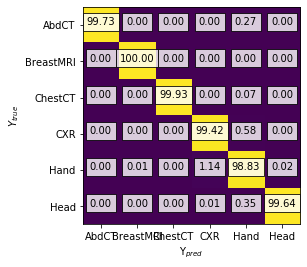

In [6]:
conf_ = np.mean(CONF, axis=0)
conf = conf_.T
conf = conf/np.sum(conf, axis=1)
plt.imshow(conf)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float(conf[i][j]*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

In [7]:
#TODO: calculate average precision, recall for each class and f1 score.
#per class precission, recall
diag = np.arange(n_classes)
acc = np.sum(conf_[diag, diag])/np.sum(conf_)*100

print('Accuracy = {:0.3f}'.format(acc))

#per class precision, recall
P = []
R = []
F = []
for i in range(n_classes):
    P.append(conf_[i,i]/np.sum(conf_[i,:]))
    R.append(conf_[i,i]/np.sum(conf_[:,i]))
    F.append(2*P[i]*R[i]/(P[i] + R[i]))
    print('{}: p = {:0.3f}, r = {:0.3f}, f = {:0.3f}'.format(classes[i], P[i]*100, R[i]*100, F[i]*100))
macro_f = sum(F)/len(F)
print('Macro-F1 score = {:0.3f}'.format(macro_f*100))

Accuracy = 99.584
AbdCT: p = 100.000, r = 99.730, f = 99.865
BreastMRI: p = 99.989, r = 100.000, f = 99.994
ChestCT: p = 100.000, r = 99.930, f = 99.965
CXR: p = 98.857, r = 99.420, f = 99.137
Hand: p = 98.731, r = 98.830, f = 98.781
Head: p = 99.980, r = 99.640, f = 99.810
Macro-F1 score = 99.592
